# 1. Instalação das Dependências





In [1]:
!pip install opencv-python tensorflow matplotlib

In [36]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='capture.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Tirar Foto';
        div.appendChild(capture);
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Captura a foto
photo_filename = take_photo()
print("Foto salva em:", photo_filename)


<IPython.core.display.Javascript object>

Foto salva em: capture.jpg


# 2. Preparação e Upload do Dataset




Faces detectadas: 2


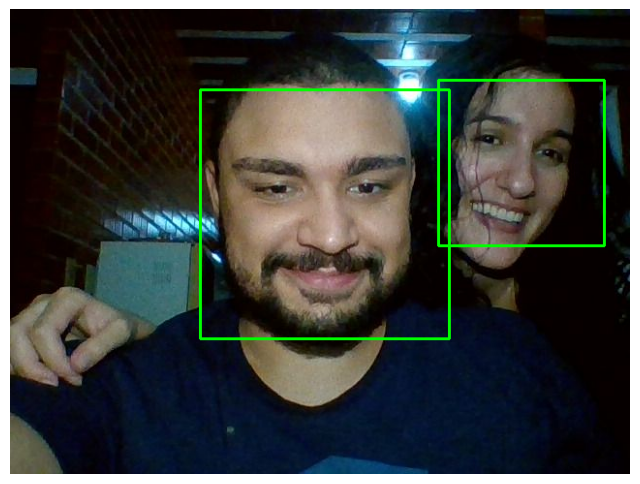

In [37]:
import cv2
import matplotlib.pyplot as plt

# Carrega o classificador Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Carrega a imagem capturada
img = cv2.imread('capture.jpg')
if img is None:
    raise ValueError("Imagem não encontrada.")

# Converte para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detecta as faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
print("Faces detectadas:", len(faces))

# Vamos armazenar as regiões de face para classificar depois
face_regions = []
for (x, y, w, h) in faces:
    face_img = img[y:y+h, x:x+w]  # recorta a face
    face_regions.append(((x, y, w, h), face_img))

# Exibe a imagem original com as caixas (sem classificação ainda)
for (x, y, w, h), _ in face_regions:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Pré-processamento

In [77]:
import os
import cv2
from PIL import Image

# Diretório base onde estão as imagens
base_dir = "/content/dataset"
classes = ["tadeu", "marina"]

# Definição do tamanho padrão
img_size = (224, 224)

# Processa as imagens para garantir tamanho e qualidade uniformes
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)

    for filename in os.listdir(class_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            file_path = os.path.join(class_dir, filename)

            # Carrega a imagem
            img = Image.open(file_path)

            # Converte para RGB (caso tenha transparência ou seja preto e branco)
            img = img.convert("RGB")

            # Redimensiona para o tamanho padrão
            img = img.resize(img_size, Image.LANCZOS)  # Substituindo ANTIALIAS por LANCZOS

            # Salva a imagem processada (sobrescrevendo a original)
            img.save(file_path, quality=95)  # Mantém boa qualidade

            print(f"Processado: {file_path}")

print("Todas as imagens foram pré-processadas com sucesso!")

Processado: /content/dataset/tadeu/2.jpg
Processado: /content/dataset/tadeu/4.jpg
Processado: /content/dataset/tadeu/5.jpg
Processado: /content/dataset/tadeu/1.jpg
Processado: /content/dataset/tadeu/6.jpg
Processado: /content/dataset/tadeu/3.jpg
Processado: /content/dataset/marina/2.jpg
Processado: /content/dataset/marina/4.jpg
Processado: /content/dataset/marina/5.jpg
Processado: /content/dataset/marina/1.jpg
Processado: /content/dataset/marina/6.jpg
Processado: /content/dataset/marina/3.jpg
Todas as imagens foram pré-processadas com sucesso!


# 3. Data Augmentation nas Imagens

In [78]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Parâmetros de data augmentation com ruído
datagen = ImageDataGenerator(
    rotation_range=20,  # Variação de ângulo
    width_shift_range=0.1,  # Pequeno deslocamento horizontal
    height_shift_range=0.1,  # Pequeno deslocamento vertical
    shear_range=0.1,  # Pequeno cisalhamento
    zoom_range=0.1,  # Pequeno zoom
    brightness_range=[0.7, 1.3],  # Variação na iluminação
    horizontal_flip=True,  # Espelhamento horizontal
    fill_mode='nearest',  # Preenchimento suave
    preprocessing_function=lambda img: np.clip(img + np.random.normal(loc=0.0, scale=0.02, size=img.shape), 0, 255)  # Adiciona ruído gaussiano
)

# Diretório base onde estão as imagens originais
base_dir = "/content/dataset"

# Classes a serem processadas
classes = ["tadeu", "marina"]

# Número de imagens aumentadas a serem geradas por imagem original
num_augmented = 7  # Mantido para gerar mais variação

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)

    # Processa cada imagem no diretório da classe
    for filename in os.listdir(class_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")) and not filename.startswith("aug"):
            img_path = os.path.join(class_dir, filename)
            img = load_img(img_path)  # Carrega a imagem (PIL)
            x = img_to_array(img)  # Converte para array numpy
            x = x.reshape((1,) + x.shape)  # Redimensiona para (1, altura, largura, canais)

            i = 0
            # Gera imagens aumentadas e salva no mesmo diretório da imagem original
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= num_augmented:
                    break  # Gera o número desejado de imagens aumentadas por original

# Exibir a contagem de imagens por classe após o aumento
def count_images():
    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        print(f"Classe {class_name}: {num_images} imagens")

count_images()

print("Data augmentation finalizado. Imagens aumentadas salvas no mesmo diretório.")

Classe tadeu: 48 imagens
Classe marina: 47 imagens
Data augmentation finalizado. Imagens aumentadas salvas no mesmo diretório.


# 4. Treinamento do Modelo de Reconhecimento Facial

In [98]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Diretório base onde estão as imagens originais
base_dir = "/content/dataset"

# Definir classes manualmente na ordem correta
classes = ["tadeu", "marina"]  # Ajustando para evitar inversão de predições

# Criando geradores de treino e validação sem data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% para validação
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=classes,  # Definindo a ordem correta
    shuffle=True  # Mantém os dados embaralhados para melhor generalização
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=classes,  # Definindo a ordem correta
    shuffle=False  # Validação não precisa ser embaralhada
)

print("Classes detectadas pelo train_generator:", train_generator.class_indices)

# Calcular pesos das classes para balanceamento
labels = np.array([train_generator.classes])
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels.flatten())
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Carrega o MobileNetV2 pré-treinado
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Inicialmente mantém congelado

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Normalização para evitar sobreajuste
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Ajustado para capturar detalhes sem exagero
x = Dropout(0.5)(x)  # Mantendo dropout adequado para melhor regularização
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento inicial
epochs = 15
if val_generator.samples == 0:
    print("Nenhuma imagem para validação. Treinando sem validação.")
    history = model.fit(
        train_generator,
        epochs=epochs,
        class_weight=class_weight_dict
    )
else:
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        class_weight=class_weight_dict
    )

# Ajuste fino liberando mais camadas do modelo
for layer in base_model.layers[-80:]:  # Liberando mais camadas para aprendizado
    layer.trainable = True

# Recompilar o modelo com taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar novamente por mais 5 épocas (ajuste fino)
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weight_dict
)

model.save("face_recognition_model.h5")

print("Modelo treinado e salvo com sucesso!")

Found 77 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
Classes detectadas pelo train_generator: {'tadeu': 0, 'marina': 1}
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4499 - loss: 7.2416 - val_accuracy: 0.5556 - val_loss: 6.6216
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5461 - loss: 7.0731 - val_accuracy: 0.6111 - val_loss: 6.5495
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6607 - loss: 6.7114 - val_accuracy: 0.6667 - val_loss: 6.4852
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7022 - loss: 6.6374 - val_accuracy: 0.7222 - val_loss: 6.4189
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8695 - loss: 6.3514 - val_accuracy: 0.7778 - val_loss: 6.3606
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6913 - loss: 6.6094 - val_accuracy: 0.8333 - val_loss: 6.3008
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8816 - loss: 6.1969 - val_accuracy: 0.8889 - val_loss: 6.2480
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8577 - loss: 6.2626 - val_accuracy: 0.9444 - val_loss: 6.2055
Epoch 9/15
3/3 ━━━━━━━━━━━

Modelo treinado e salvo com sucesso!


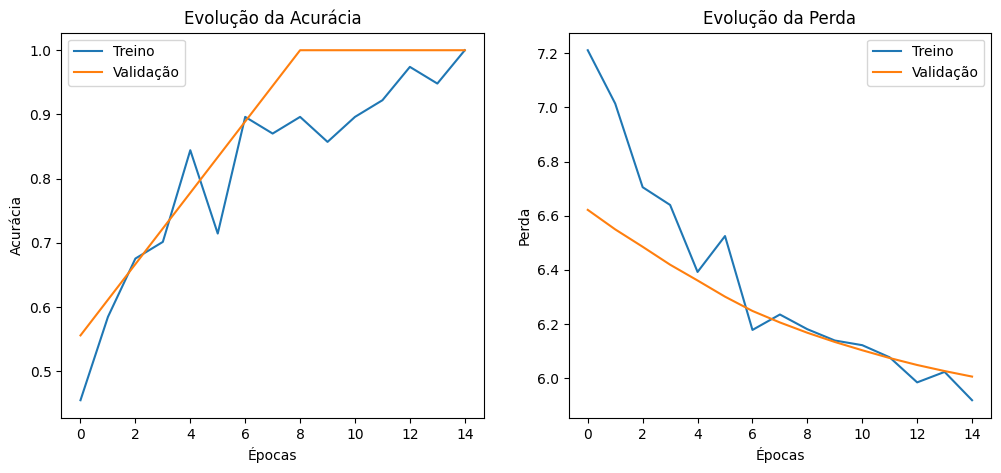

In [100]:
import matplotlib.pyplot as plt

# Exibir precisão e perda do modelo
plt.figure(figsize=(12,5))

# Gráfico da acurácia
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da Acurácia')

# Gráfico da perda
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Evolução da Perda')

plt.show()


# 5. Detecção de Rostos na Imagem de Teste e Classificação de rosto



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


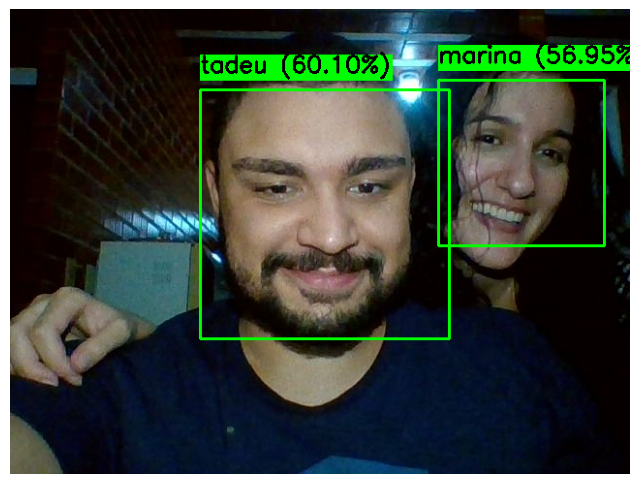

In [101]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = tf.keras.models.load_model("face_recognition_model.h5")

# Lista de classes, na mesma ordem do treinamento:
class_labels = ["marina", "tadeu"]

# Parâmetros de pré-processamento (tamanho esperado pelo modelo)
IMG_SIZE = (224, 224)

# Supondo que 'face_regions' já foi definida e contém tuplas do formato: ((x, y, w, h), face_img)
# Exemplo: face_regions = [((x, y, w, h), face_img), ...]

# Carrega a imagem original para desenhar os rótulos
img_original = cv2.imread('capture.jpg')
if img_original is None:
    raise ValueError("Imagem 'capture.jpg' não encontrada!")

for ((x, y, w, h), face_img) in face_regions:
    # Redimensiona a face para o tamanho esperado pelo modelo
    face_resized = cv2.resize(face_img, IMG_SIZE)
    # Normaliza a imagem (0 a 1)
    face_resized = face_resized.astype("float32") / 255.0
    # Adiciona dimensão de batch
    face_input = np.expand_dims(face_resized, axis=0)

    # Faz a predição
    preds = model.predict(face_input)
    class_id = int(np.argmax(preds))
    confidence = float(np.max(preds))

    # Verifica se o índice predito está dentro do intervalo esperado
    if class_id < len(class_labels):
        name = class_labels[class_id]
    else:
        name = "Desconhecido"

    confidence_percent = confidence * 100

    # Cria o label de texto
    label = f"{name} ({confidence_percent:.2f}%)"

    # Calcula o tamanho do texto para desenhar um fundo
    font_scale = 0.8
    thickness = 2
    (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

    # Define coordenadas para o retângulo de fundo do label
    # Ajusta a posição para que o fundo fique acima do bounding box, sem sair da imagem
    label_x = x
    label_y = y - 10 if y - 10 > text_height + baseline else y + text_height + baseline + 10

    # Desenha o retângulo preenchido como fundo (cor verde, mas pode ajustar)
    cv2.rectangle(img_original, (label_x, label_y - text_height - baseline), (label_x + text_width, label_y), (0, 255, 0), cv2.FILLED)

    # Escreve o texto em cima do retângulo, com cor preta
    cv2.putText(img_original, label, (label_x, label_y - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)

    # Desenha o bounding box da face
    cv2.rectangle(img_original, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Exibe a imagem final com labels aprimorados
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
